In [2]:
from __future__ import division

## 图片风格迁移 Neural Style Transfer
A Neural Algorit[链接文字](https://arxiv.org/pdf/1508.06576.pdf)hm of Artistic Style 本文介绍了Neural Style Transfor模型

[Demystifying Neural Style Transfer](https://arxiv.org/pdf/1701.01036.pdf)

In [3]:
%matplotlib inline


from torchvision import models
from torchvision import transforms
from PIL import Image
import argparse
import torch
import torchvision
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Load image

In [4]:
def load_image(image_path, transform=None, max_size=None, shape=None):
  image = Image.open(image_path)
  if max_size:
    scale = max_size / max(image.size)
    size = np.array(image.size) * scale
    image = image.resize(size.astype(int), Image.ANTIALIAS)

  if shape:
    image = image.resize(shape, Image.LANCZOS)
  
  if transform:
    image = transform(image).unsqueeze(0)
  
  return image.to(device)

transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

content = load_image("content_2000.jpeg",transform, max_size=2000)
style = load_image('style_2000.jpeg', transform, shape=[content.size(2), content.size(3)])

In [5]:
content.shape

torch.Size([1, 3, 1500, 2000])

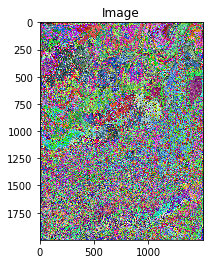

In [6]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style[0], title='Image')
# content.shape

### Define VGGnet

In [7]:
vgg = models.vgg19(pretrained=True)
vgg # has "features" and "classifier"

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [8]:
class VGGNet(nn.Module):
  def __init__(self):
    super(VGGNet, self).__init__()
    self.select = ['0', '5', '10', '19', '28'] #only need these 5 layers in vgg19.features
    self.vgg = models.vgg19(pretrained=True).features
  
  def forward(self,x):
    features = []
    for name, layer in self.vgg._modules.items():
      x = layer(x)
      if name in self.select:
        features.append(x)
    return features

vgg = VGGNet().to(device).eval()

In [ ]:
features = vgg(content)
features[0].shape

In [22]:
for feat in features:
  print(feat.shape)

torch.Size([1, 64, 266, 400])
torch.Size([1, 128, 133, 200])
torch.Size([1, 256, 66, 100])
torch.Size([1, 512, 33, 50])
torch.Size([1, 512, 16, 25])


In [0]:
target = content.clone().requires_grad_(True)
optimizer = torch.optim.Adam([target], lr=0.003, betas=[0.5, 0.999])

Optimize the target image

In [24]:
total_step = 2000
for step in range(total_step):
  target_features = vgg(target)
  content_features = vgg(content)
  style_features = vgg(style)

  content_loss = 0.
  style_loss = 0.
  for f1, f2, f3 in zip(target_features, content_features, style_features):
    content_loss += torch.mean((f1-f2)**2)
    _, c, h, w = f1.size()
    f1 = f1.view(c, h*w) # c, h * w
    f3 = f3.view(c, h*w)

    f1 = torch.mm(f1, f1.t()) # c, c
    f3 = torch.mm(f3, f3.t()) # c, c
    style_loss += torch.mean((f1-f3)**2) / (c*h*w)
  
  loss = content_loss + style_loss * 100

  # update the target image tensor
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if step % 100 == 0:
    print("Step [{}/{}], Content Loss: {:.4f}, Style Loss: {:.4f}"
    .format(step, total_step, content_loss.item(), style_loss.item()))




Step [0/2000], Content Loss: 0.0000, Style Loss: 1397.2328


KeyboardInterrupt: ignored

In [0]:
denorm = transforms.Normalize([-2.12, -2.04, -1.80],[4.37, 4.46, 4.44])
img = target.clone().squeeze()
img = denorm(img).clamp_(0,1)
#plt.figure()
imshow(img, title="Target Image")